# Step-wise Feature selection
Forward step-wise selection of the best features to use, following a greedy approach.

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.base import clone

In [2]:
path = "features/"
filenames = ["symptoms.npz", "betweennes.npz", "community_count.npz", "community_size.npz", "ks_level_1.npz", "ks_level_2.npz"]
names = ["symptoms", "betweenness", "community_count", "community_size", "ks_level_1", "ks_level_2"]
sample_percentage = 0.1
parameters = {'C': 0.001, 'solver': 'liblinear'}
model = LogisticRegression(**parameters)

In [3]:
#load features from .npz files
labels = np.load(path + filenames[0])['y']
num_samples = int(labels.shape[0] * sample_percentage)
sampled_indices = np.random.choice(labels.shape[0], num_samples, replace=False)
labels = labels[sampled_indices]
features = []
for filename in filenames:
    file_path = path + filename
    data = np.load(file_path)
    feature_matrix = data['X']
    feature_matrix = feature_matrix[sampled_indices, :]
    features.append(feature_matrix)

# Perform feature selection and record accuracies
num_features = len(features)
remaining_features = list(range(num_features))
already_used_features = []
accuracies = []

# Initial null model with the first feature
X_train, X_test, y_train, y_test = train_test_split(features[0], labels, test_size=0.2, random_state=42)
# Perform logistic regression and compute accuracy
model_ = clone(model)
model_.fit(X_train, y_train)
y_pred = model_.predict(X_test)
null_model_accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline model: accuracy = {null_model_accuracy*100:4.2f}.")
accuracies.append(null_model_accuracy)
remaining_features.pop(0)
already_used_features.append(0)

# Feature selection iterations
it = 0
accuracy_matrix = np.zeros((num_features-1, num_features-1))
while remaining_features:
    best_accuracy = 0
    best_feature = None

    for feature_index in remaining_features:
        current_features = already_used_features + [feature_index]
        X = np.hstack([features[i] for i in current_features])

        X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)
        # Perform logistic regression and compute accuracy
        model_ = clone(model)
        model_.fit(X_train, y_train)
        y_pred = model_.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        accuracy_matrix[it][feature_index-1] = accuracy
        print(f"Model [{it}][{feature_index}]: accuracy = {accuracy*100:4.2f}.")
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_feature = feature_index

    # Update lists
    accuracies.append(best_accuracy)
    remaining_features.remove(best_feature)
    already_used_features.append(best_feature)
    it += 1

Baseline model: accuracy = 42.70.
Model [0][1]: accuracy = 42.68.
Model [0][2]: accuracy = 16.54.
Model [0][3]: accuracy = 83.66.
Model [0][4]: accuracy = 73.33.
Model [0][5]: accuracy = 69.59.
Model [1][1]: accuracy = 83.66.
Model [1][2]: accuracy = 83.66.
Model [1][4]: accuracy = 83.76.
Model [1][5]: accuracy = 83.66.
Model [2][1]: accuracy = 83.76.
Model [2][2]: accuracy = 83.76.
Model [2][5]: accuracy = 83.76.
Model [3][2]: accuracy = 83.76.
Model [3][5]: accuracy = 83.76.
Model [4][5]: accuracy = 83.76.


In [4]:
already_used_features

[0, 3, 4, 1, 2, 5]

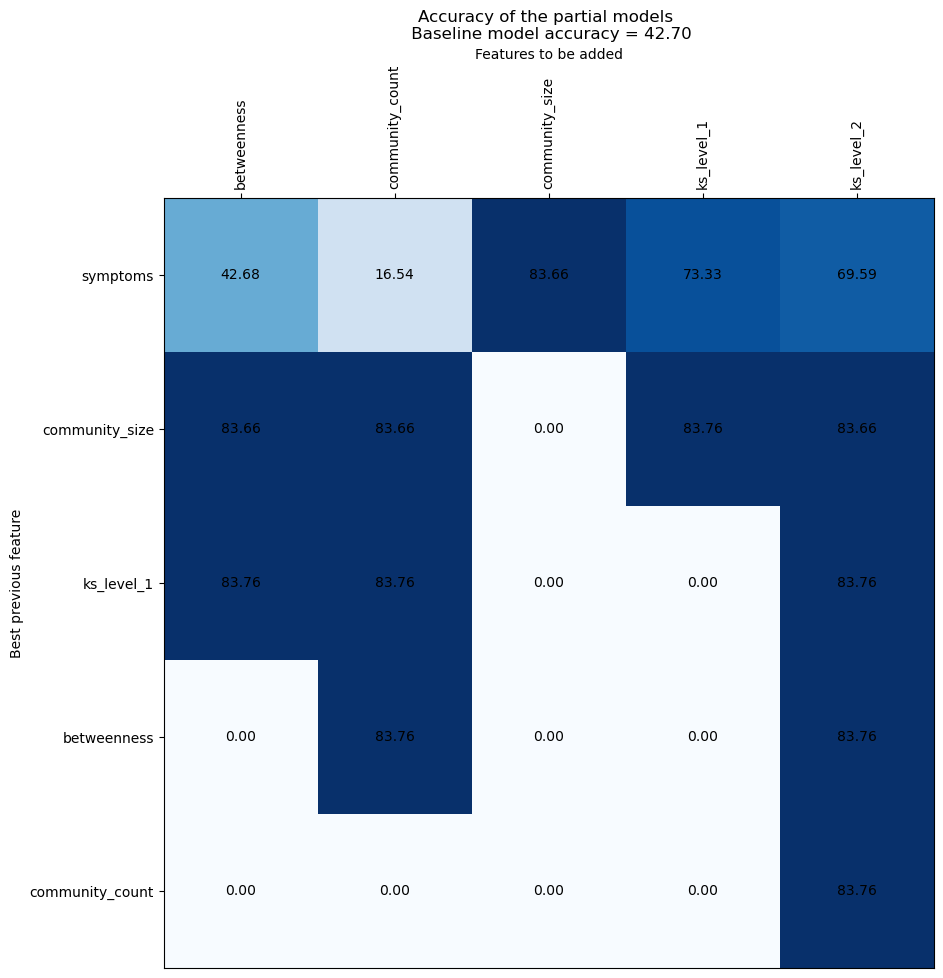

In [5]:
# Plot model accuracies
plt.figure(figsize=(10, 10))
plt.imshow(accuracy_matrix, cmap="Blues")
tick_marks = np.arange(num_features-1)
reordered_names = [names[i] for i in already_used_features]
plt.xticks(tick_marks, labels=names[1:], rotation='vertical', ha='center')  # Set custom tick marks
plt.yticks(tick_marks, labels=reordered_names[:-1])
ax = plt.gca()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xlabel("Features to be added")
plt.ylabel("Best previous feature")
for i in range(num_features-1):
    for j in range(num_features-1):
        val = accuracy_matrix[i, j]*100
        plt.text(j, i,f"{val:4.2f}", ha='center', va='center')
plt.title(f"Accuracy of the partial models \n Baseline model accuracy = {null_model_accuracy*100:4.2f}")
plt.show()

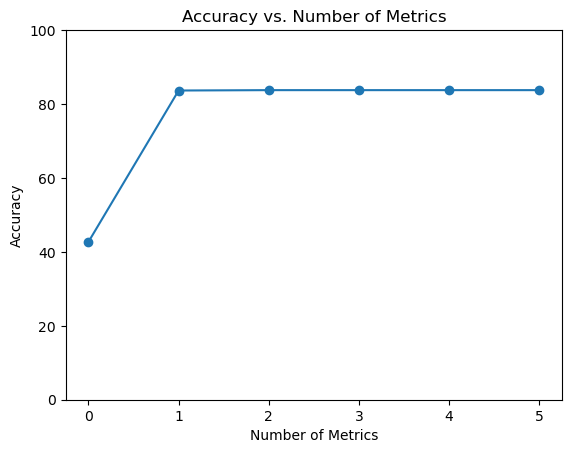

In [8]:
# Plot accuracies for each best model
plt.plot(range(len(accuracies)), np.array(accuracies)*100, marker='o')
plt.xlabel('Number of Metrics')
plt.ylabel('Accuracy')
plt.ylim(0, 100)
plt.title('Accuracy vs. Number of Metrics')
plt.show()

In [9]:
accuracies

[0.4270095160963758,
 0.8366066005264223,
 0.8376189512046973,
 0.8376189512046973,
 0.8376189512046973,
 0.8376189512046973]